In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import string, os 
import re
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.4.1


In [4]:
batch_size = 64  # Batch size for training.
epochs = 200  # Number of epochs to train for.
latent_dim = 512  # Latent dimensionality of the encoding space.
num_samples = 50000

In [5]:
# reading dataset
df = pd.read_csv('../input/chatbot-dataset-topical-chat/topical_chat.csv')
df.head()

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


In [6]:
# basic preprocessing
def process(text):
    text = text.lower().replace('\n', ' ').replace('-', ' ').replace(':', ' ').replace(',', '') \
          .replace('"', ' ').replace(".", " ").replace("!", " ").replace("?", " ").replace(";", " ").replace(":", " ")

    text = "".join(v for v in text if v not in string.punctuation).lower()
    #text = text.encode("utf8").decode("ascii",'ignore')

    text = " ".join(text.split())
    #text+="<eos>"
    return text


In [8]:
df.message = df.message.apply(process)

In [7]:
df.head()

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


In [8]:
# Vectorize the data.
input_texts = []
target_texts = []
input_words_set = set()
target_words_set = set()

for conversation_index in tqdm(range(df.shape[0])):
    
    if conversation_index == 0:
        continue
        
    input_text = df.iloc[conversation_index - 1]
    target_text = df.iloc[conversation_index]
    
    if input_text.conversation_id == target_text.conversation_id:
        
        input_text = input_text.message
        target_text = target_text.message
        
        if len(input_text.split()) > 2 and \
            len(target_text.split()) > 0 and \
            len(input_text.split()) < 30 and \
            len(target_text.split()) < 10 and \
            input_text and \
            target_text:
            
            target_text = "bos " + target_text + " eos"
                
            input_texts.append(input_text)
            target_texts.append(target_text)
            
            for word in input_text.split():
                if word not in input_words_set:
                    input_words_set.add(word)
            for word in target_text.split():
                if word not in target_words_set:
                    target_words_set.add(word)

100%|██████████| 188378/188378 [01:02<00:00, 2995.69it/s]


In [11]:
input_texts

['yes google is the biggest search engine and google service figure out top 100 website including youtube and blogger',
 'yes he even won a hardcore cha cha championship in 1958',
 'true did you know jackson had a patent on a dancing device',
 'yes it helped him smooth out his dance moves',
 'i wonder if they met how that would go from there',
 'oh yeah i didnt know that either i also want to go to google plex to see the goats who mow their lawn by eating it',
 'hi do you like to dance',
 'dancing is a lot of fun did you know that bruce lee was a great dancer',
 'he was indeed his music is even in the library of congress',
 'wow that is amazing coming from such a talented singer and dancer i couldnt even dance like that even if i dreamed of it',
 'i heard that some professional ballet dancer can go through four pairs of shoes in a week',
 'ha ha it was so nice chatting with you as well have a nice day bye',
 'yes he was in the nutcracker as the mouse king',
 'i wonder if they had met w

In [12]:
target_texts

['bos by the way do you like fish eos',
 'bos yeah did you know tupac was a ballet dancer eos',
 'bos yes it helped him smooth out his dance moves eos',
 'bos nice do you like shakespeare eos',
 'bos yeah interesting point nice chat eos',
 'bos say what now they have that eos',
 'bos i love to dance a lot how about you eos',
 'bos i heard that winning cha cha championships and everything eos',
 'bos i didnt know this thanks for sharing eos',
 'bos me neither i could never be a professional dancer eos',
 'bos that is crazy that cant be cheap for them eos',
 'bos bye eos',
 'bos yeah do you like shakespeare eos',
 'bos yeah good point he also invented some womens names eos',
 'bos yes among those are olivia miranda and jessica eos',
 'bos do you know how google maps calculates traffic eos',
 'bos i am not sure how do they do this eos',
 'bos they track how fast android devices are moving eos',
 'bos no i have what does the results turn eos',
 'bos i do like comic books eos',
 'bos hahah 

In [13]:
import tensorflow_datasets as tfds

import os
import re
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
MAX_SENTENCE_LENGTH = 60

In [14]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    input_texts + target_texts, target_vocab_size=2**13)

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

VOCAB_SIZE = tokenizer.vocab_size + 2

In [15]:
def tokenize_and_filter(input_texts, target_texts):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(input_texts, target_texts):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_SENTENCE_LENGTH and len(sentence2) <= MAX_SENTENCE_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_SENTENCE_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_SENTENCE_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


input_texts, target_texts = tokenize_and_filter(input_texts, target_texts)

In [16]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(input_texts)))

Vocab size: 8049
Number of samples: 20207


In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': input_texts,
        'dec_inputs': target_texts[:, :-1]
    },
    {
        'outputs': target_texts[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Attention

In [20]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

# Transformer

**Masking**

In [23]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [24]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [26]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [27]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


# Positional Encoding

In [28]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

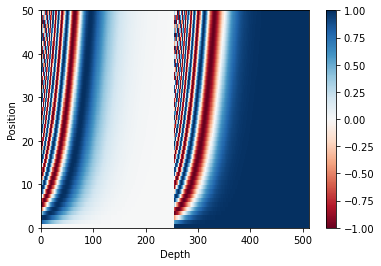

In [29]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Encoder Layer

**1) Multi head attention
2) Two dense layers followed by dropout**

In [30]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

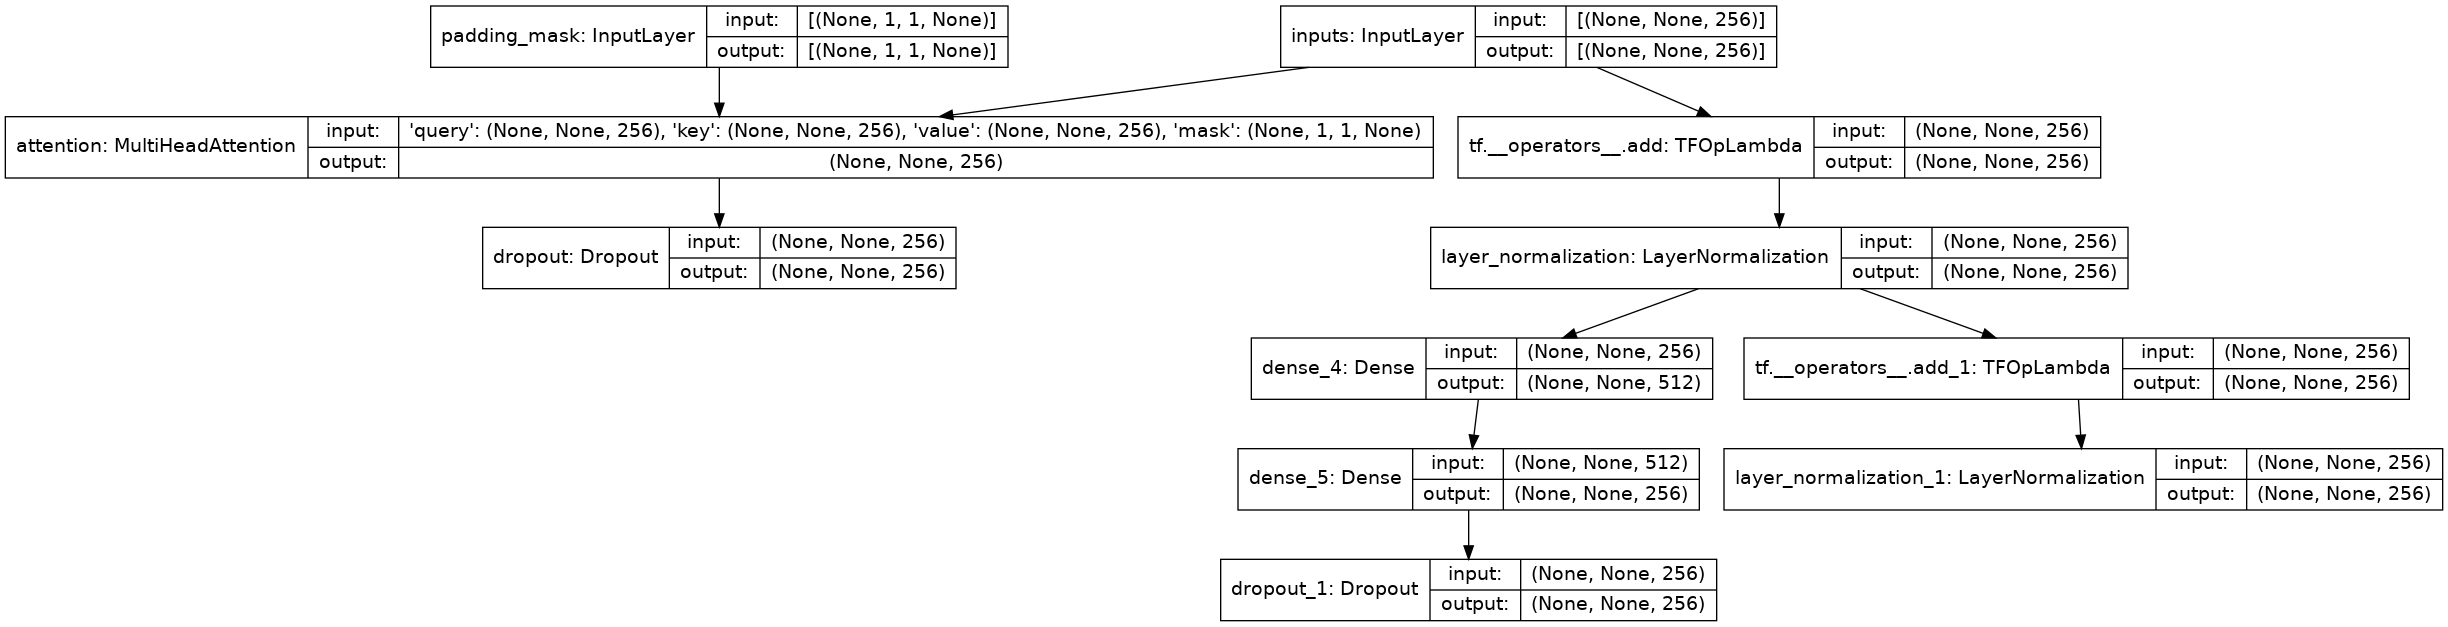

In [31]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.1,
    name="our_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

# Encoder : It consists of 
# 
# a) Input emdedding
# b) Positional Encoding
# c) num_layers encoder layers

In [32]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

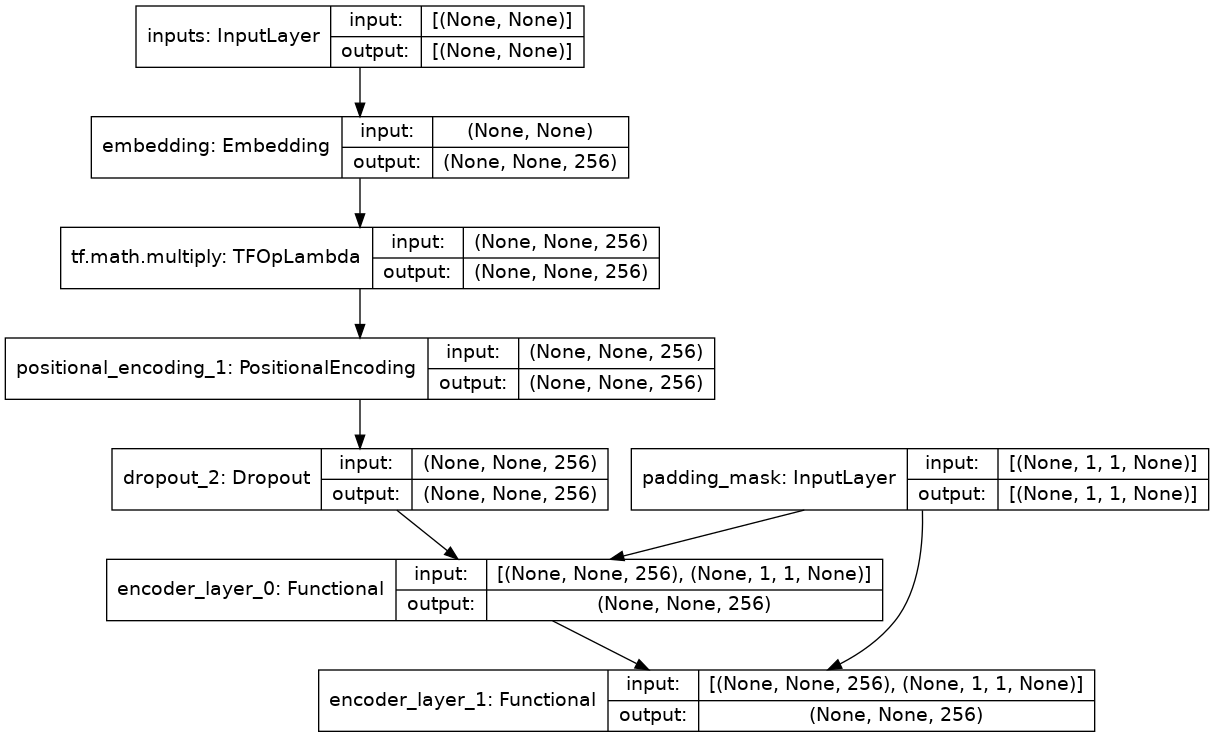

In [33]:
sample_encoder = encoder(
    vocab_size=8515,
    num_layers=2,
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.1,
    name="our_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

**Decoder Layer

Each consists of:
a) Masked multi self head attention
b) Multi head attention(with padding mask) . value and key receive the encoder output as inputs. query receives the output from the masked multi-head attention sublayer.
c) 2 dense layers followed by dropout**

In [34]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

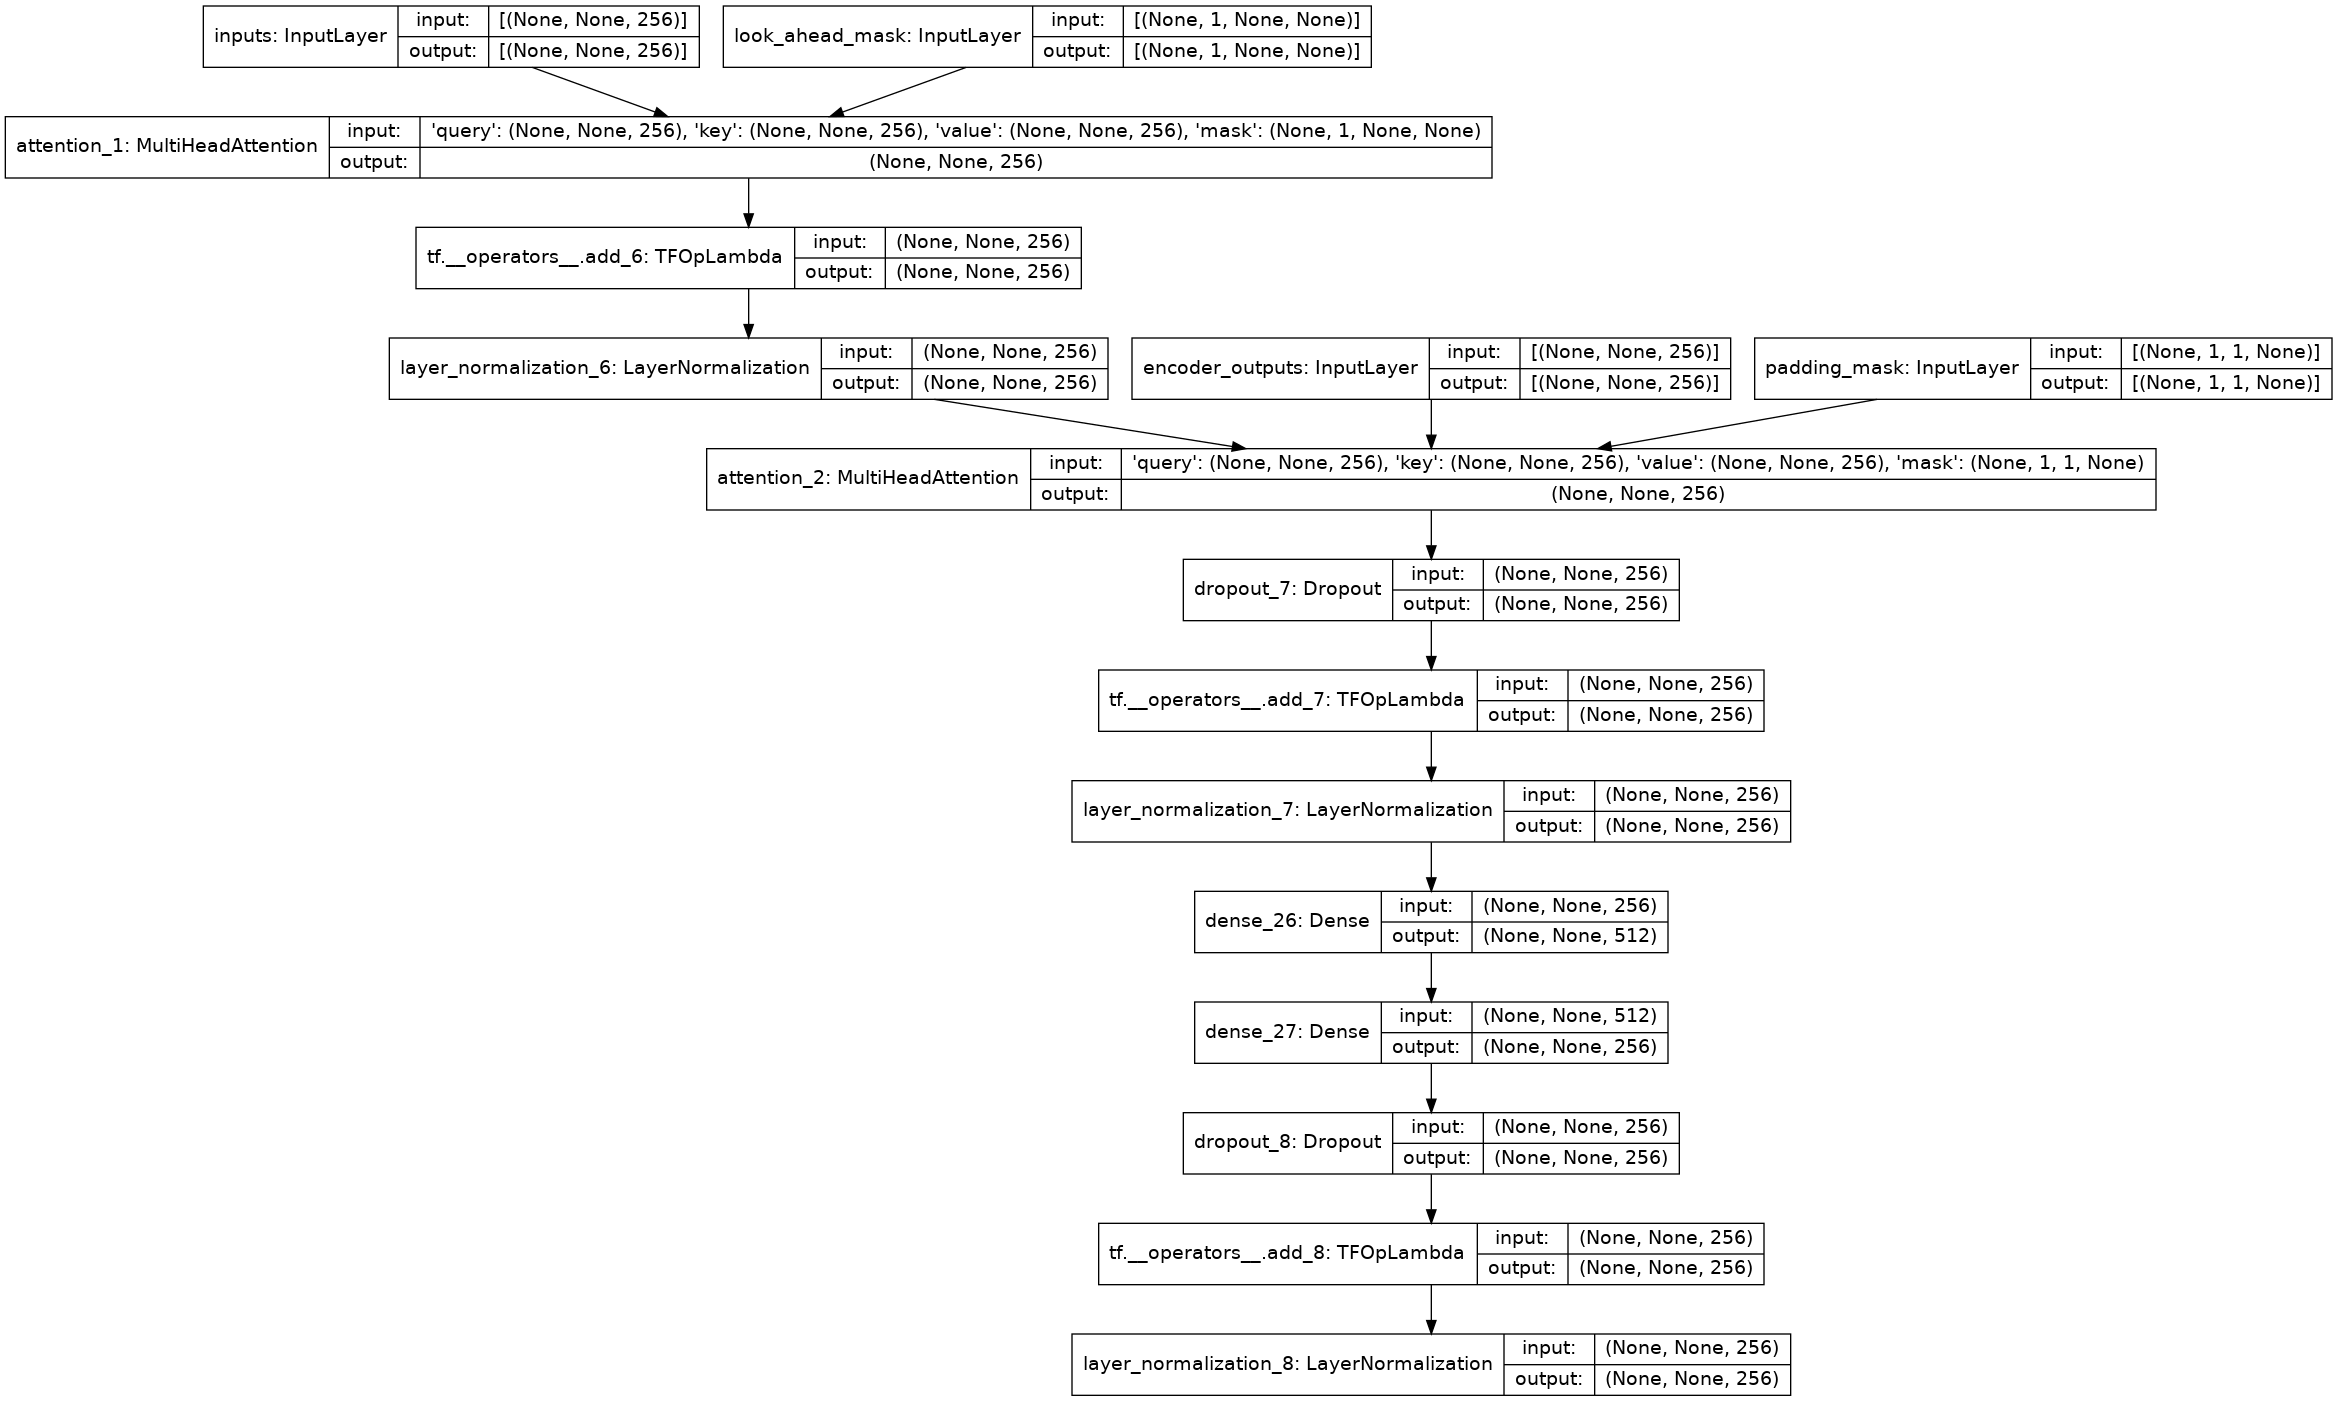

In [35]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.1,
    name="our_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

**Decoder
The Decoder consists of:

1) Output Embedding
2) Positional Encoding
3) N decoder layers**

In [36]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

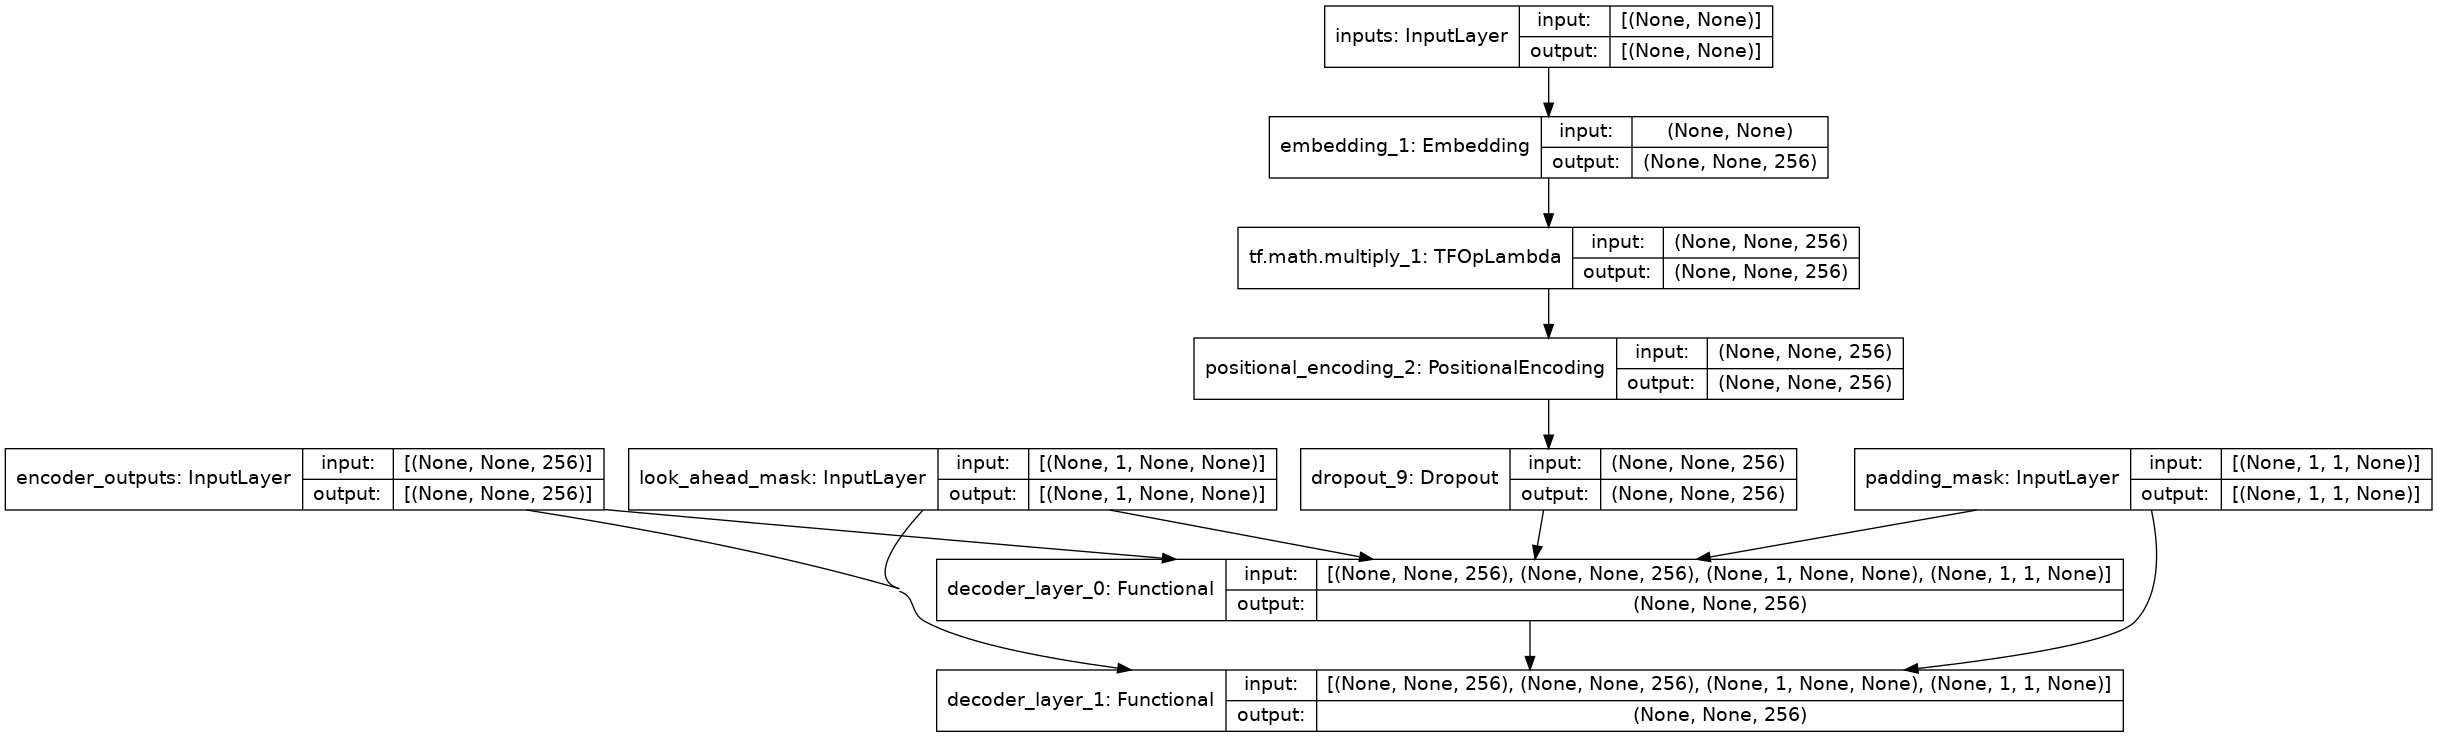

In [37]:
sample_decoder = decoder(
    vocab_size=8515,
    num_layers=2,
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.1,
    name="our_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

# Transformer
**Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.**

In [38]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

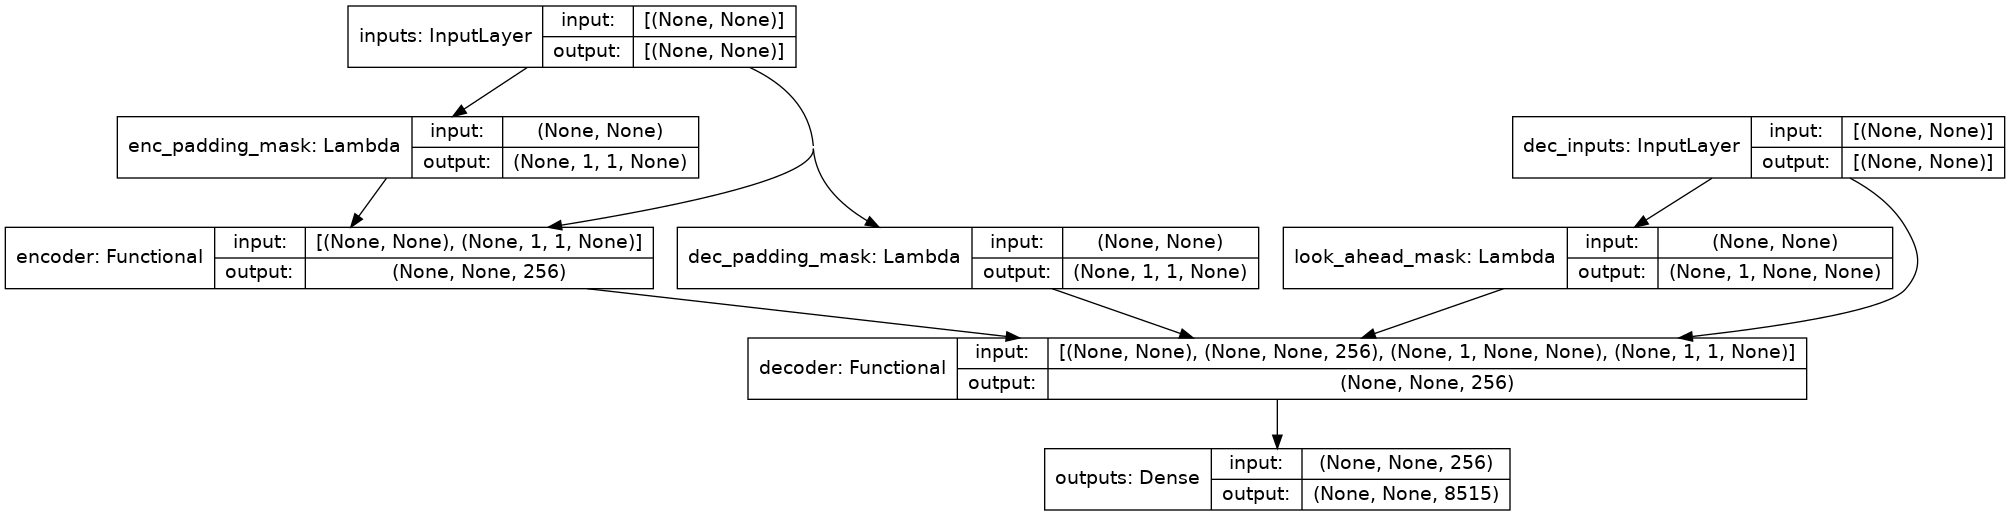

In [39]:
sample_transformer = transformer(
    vocab_size=8515,
    num_layers=2,
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.1,
    name="our_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

**Train the model**

In [41]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

In [42]:
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

# Loss function

In [43]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_SENTENCE_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

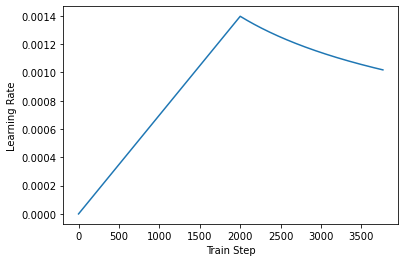

In [45]:
sample_learning_rate = CustomSchedule(d_model=256)

plt.plot(sample_learning_rate(tf.range(3768, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

**Compile the model**

In [46]:
def perplexity(real, pred):
    """
    This function returns the perplexity for model's predictions on a batch 
    of data in comparison with the real outputs at a timestep.
    Arguments:
        real: real output, a Tensorflow tensor with a shape 
              of: (batch_size, max_seq_length)
        pred: model's predictions at a certain timestep, a Tensorflow tensor 
              with a shape of: (batch_size, max_seq_length)
    Returns:
        A Tensorflow tensor with the perplexity.
    """
    real = tf.reshape(real, shape=(-1, MAX_SENTENCE_LENGTH - 1))
    loss = loss_function(real, pred)
    
    return tf.cast(tf.pow(math.e, loss), dtype=tf.keras.backend.floatx())

In [51]:
def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_SENTENCE_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_SENTENCE_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [54]:
# Using len() to get the number of rows (length of the dataset)
num_rows = len(df)
print(f"The dataset has {num_rows} rows.")

# Using shape to get both rows and columns
rows, columns = df.shape
print(f"The dataset has {rows} rows and {columns} columns.")

The dataset has 188378 rows.
The dataset has 188378 rows and 3 columns.


In [52]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy, perplexity], run_eagerly=True)

In [55]:
EPOCHS = 100

history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/100
316/316 [==============================] - 66s 208ms/step - loss: 0.5142 - accuracy: 0.1222 - perplexity: 1.6739
Epoch 2/100
316/316 [==============================] - 65s 207ms/step - loss: 0.4709 - accuracy: 0.1262 - perplexity: 1.6026
Epoch 3/100
316/316 [==============================] - 65s 207ms/step - loss: 0.4163 - accuracy: 0.1324 - perplexity: 1.5173
Epoch 4/100
316/316 [==============================] - 66s 208ms/step - loss: 0.3658 - accuracy: 0.1398 - perplexity: 1.4424
Epoch 5/100
316/316 [==============================] - 66s 208ms/step - loss: 0.3210 - accuracy: 0.1474 - perplexity: 1.3791
Epoch 6/100
316/316 [==============================] - 65s 207ms/step - loss: 0.2844 - accuracy: 0.1542 - perplexity: 1.3293
Epoch 7/100
316/316 [==============================] - 65s 207ms/step - loss: 0.2534 - accuracy: 0.1601 - perplexity: 1.2888
Epoch 8/100
316/316 [==============================] - 66s 207ms/step - loss: 0.2285 - accuracy: 0.1651 - perplexity: 1.2571


In [56]:
history

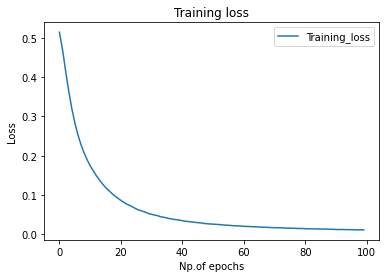

<Figure size 432x288 with 0 Axes>

In [57]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='Training_loss')
plt.legend()
plt.title('Training loss')
plt.xlabel('Np.of epochs')
plt.ylabel('Loss')
plt.show()
plt.savefig('Loss_Graph')

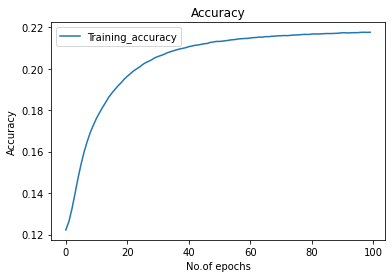

<Figure size 432x288 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='Training_accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('No.of epochs')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('Loss_Graph')

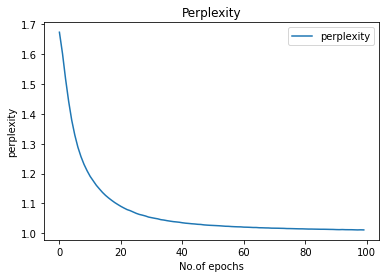

<Figure size 432x288 with 0 Axes>

In [59]:
import matplotlib.pyplot as plt
plt.plot(history.history['perplexity'],label='perplexity')
plt.legend()
plt.title('Perplexity')
plt.xlabel('No.of epochs')
plt.ylabel('perplexity')
plt.show()
plt.savefig('Loss_Graph')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def predict_expression(image_path, model_path="model.h5", target_size=(48, 48)):
    """
    Predicts the expression of a given image using a pre-trained model.

    Parameters:
        image_path (str): Path to the image for prediction.
        model_path (str): Path to the saved model file. Default is 'model.h5'.
        target_size (tuple): Size to which the image will be resized. Default is (48, 48).

    Returns:
        str: Predicted expression class label.
    """
    # Load the trained model
    model = load_model(model_path)

    # Load and preprocess the image
    image = load_img(image_path, target_size=target_size, color_mode='grayscale')
    image_array = img_to_array(image) / 255.0  # Normalize pixel values to [0, 1]
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Predict using the model
    predictions = model.predict(image_array)
    predicted_class = np.argmax(predictions, axis=-1)[0]  # Get the class with highest probability

    # Define class labels (update according to your dataset's classes)
    class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    predicted_label = class_labels[predicted_class]

    return predicted_label

# Example usage:
image_path = "path_to_test_image.jpg"
predicted_expression = predict_expression(image_path)
print(f"The predicted expression is: {predicted_expression}")


In [62]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

def predict_chatbot_response(user_input, model_path="path_to_trained_model"):
    """
    Predicts a response to a given user input using a pre-trained chatbot model.

    Parameters:
        user_input (str): The user's input message.
        model_path (str): Path to the saved pre-trained model. Default is 'path_to_trained_model'.

    Returns:
        str: The chatbot's response.
    """
    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)

    # Preprocess the user input
    input_ids = tokenizer.encode(user_input, return_tensors="tf", truncation=True, padding="max_length", max_length=128)

    # Generate the chatbot response
    output_ids = model.generate(
        input_ids,
        max_length=50,  # Maximum length of the generated response
        num_beams=5,  # Beam search for better responses
        no_repeat_ngram_size=2,  # Avoid repeating phrases
        early_stopping=True  # Stop generation when an end condition is met
    )

    # Decode the generated response
    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return response

# Example usage:
user_message = "What is the capital of France?"
response = predict_chatbot_response(user_message, model_path=""D:\nlp project final"")
print(f"Chatbot: {response}")


SyntaxError: invalid syntax (<ipython-input-62-869c19cf950f>, line 38)

In [65]:
# Save the model to a directory
model.save("/kaggle/input/chatbot-dataset-topical-chat")


NotImplementedError: Learning rate schedule must override get_config